In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats

In [27]:
# Load the dataset
file_path = 'stations.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,stop_id,Station Name,Distance from Start (km),Line,Station Layout,Latitude,Longitude
0,1,Jhil Mil,10.3,Red line,Elevated,28.675790,77.312390
1,2,Welcome [Conn: Red],46.8,Pink line,Elevated,28.671800,77.277560
2,3,DLF Phase 3,10.0,Rapid Metro,Elevated,28.493600,77.093500
3,4,Okhla NSIC,23.8,Magenta line,Elevated,28.554483,77.264849
4,5,Dwarka Mor,10.2,Blue line,Elevated,28.619320,77.033260


Select Features and Remove Outliers

In [28]:
# Select relevant features for clustering
features = data[['Distance from Start (km)', 'Latitude', 'Longitude']]

# Compute Z-scores for outlier detection and remove outliers
z_scores = np.abs(stats.zscore(features))
data_clean = data[(z_scores < 3).all(axis=1)]

# Select cleaned features
features_clean = data_clean[['Distance from Start (km)', 'Latitude', 'Longitude']]

# Display the number of rows before and after outlier removal
print(f"Rows before outlier removal: {data.shape[0]}")
print(f"Rows after outlier removal: {data_clean.shape[0]}")

Rows before outlier removal: 285
Rows after outlier removal: 282


Standardize the Features


In [29]:
# Standardize the features
mean = np.mean(features_clean, axis=0)
std = np.std(features_clean, axis=0)
scaled_features_clean = (features_clean - mean) / std

 K-Means Clustering Functions

In [30]:
# Function to compute the distance between points and centroids
def compute_distances(data, centroids):
    distances = np.zeros((data.shape[0], centroids.shape[0]))
    for i in range(centroids.shape[0]):
        distances[:, i] = np.sqrt(np.sum((data - centroids[i]) ** 2, axis=1))
    return distances

# Function to update centroids based on the mean of the clusters
def update_centroids(data, labels, n_clusters):
    new_centroids = []
    for i in range(n_clusters):
        cluster_points = data[labels == i]
        if cluster_points.shape[0] > 0:
            new_centroids.append(np.mean(cluster_points, axis=0))
        else:
            new_centroids.append(np.zeros(data.shape[1]))
    return np.array(new_centroids)

# Function to perform K-Means clustering manually
def kmeans_manual(data, n_clusters, max_iters=100, tol=1e-4):
    np.random.seed(42)
    initial_indices = np.random.choice(data.shape[0], n_clusters, replace=False)
    centroids = data[initial_indices]
    for _ in range(max_iters):
        distances = compute_distances(data, centroids)
        labels = np.argmin(distances, axis=1)
        new_centroids = update_centroids(data, labels, n_clusters)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return labels, centroids

K-Means Clustering and Visualize

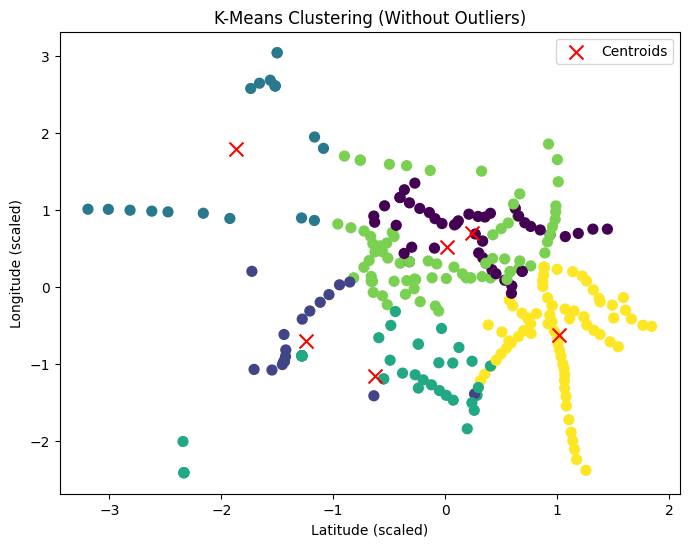

In [31]:
# Set number of clusters
n_clusters = 6

# Perform manual K-Means clustering
labels_manual, centroids_manual = kmeans_manual(scaled_features_clean.values, n_clusters)

# Visualize the resulting clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features_clean['Latitude'], scaled_features_clean['Longitude'], c=labels_manual, cmap='viridis', s=50)
plt.scatter(centroids_manual[:, 1], centroids_manual[:, 2], c='red', marker='x', s=100, label='Centroids')
plt.title('K-Means Clustering (Without Outliers)')
plt.xlabel('Latitude (scaled)')
plt.ylabel('Longitude (scaled)')
plt.legend()
plt.show()

Compute Silhouette Score and Plot Average Silhouette Score per Cluster


Overall Silhouette Score: 0.33459308261729287


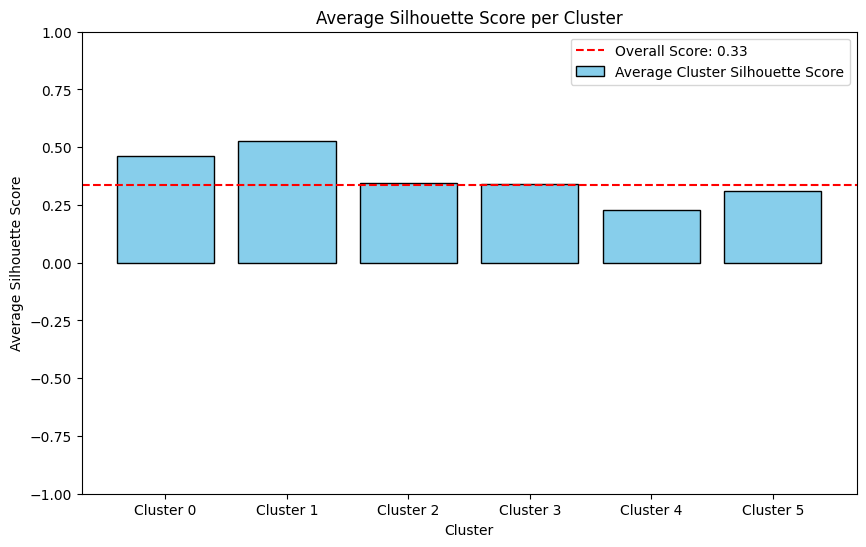

In [37]:
# Compute the overall silhouette score manually
silhouette_scores = []
for i, point in enumerate(scaled_features_clean.values):
    same_cluster = scaled_features_clean.values[labels_manual == labels_manual[i]]
    other_points = scaled_features_clean.values[labels_manual != labels_manual[i]]
    other_labels = labels_manual[labels_manual != labels_manual[i]]

    if same_cluster.shape[0] > 1:
        # Compute intra-cluster distance (a)
        a = np.mean(np.linalg.norm(same_cluster - point, axis=1))

        # Compute inter-cluster distance (b)
        b = np.min([
            np.mean(np.linalg.norm(other_points[other_labels == j] - point, axis=1))
            for j in range(n_clusters) if np.any(other_labels == j)
        ])

        # Silhouette score for the point
        silhouette_scores.append((b - a) / max(a, b))
    else:
        silhouette_scores.append(0)  # Single-point cluster

# Compute the overall silhouette score
overall_silhouette_score = np.mean(silhouette_scores)
print(f'Overall Silhouette Score: {overall_silhouette_score}')

# Compute average silhouette score per cluster
cluster_avg_silhouette = []
for i in range(n_clusters):
    ith_cluster_scores = [silhouette_scores[j] for j in range(len(labels_manual)) if labels_manual[j] == i]
    cluster_avg_silhouette.append(np.mean(ith_cluster_scores) if ith_cluster_scores else 0)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
clusters = range(n_clusters)
plt.bar(clusters, cluster_avg_silhouette, color='skyblue', edgecolor='black', label='Average Cluster Silhouette Score')
plt.axhline(y=overall_silhouette_score, color='red', linestyle='--', label=f'Overall Score: {overall_silhouette_score:.2f}')
plt.title("Average Silhouette Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Silhouette Score")
plt.xticks(clusters, [f'Cluster {i}' for i in clusters])
plt.ylim(-1, 1)  # Silhouette scores range from -1 to 1
plt.legend()
plt.show()


Compute Cluster Insights and Display

In [38]:
# Compute insights from the clustering results
cluster_insights = pd.DataFrame({
    'Cluster': labels_manual,
    'Distance from Start (km)': features_clean['Distance from Start (km)'].values,
    'Latitude': features_clean['Latitude'].values,
    'Longitude': features_clean['Longitude'].values
})

# Summary of each cluster
cluster_summary = cluster_insights.groupby('Cluster').agg({
    'Distance from Start (km)': ['mean', 'min', 'max'],
    'Latitude': ['mean', 'min', 'max'],
    'Longitude': ['mean', 'min', 'max']
}).reset_index()

# Rename columns for better readability
cluster_summary.columns = ['Cluster',
                           'Distance Mean', 'Distance Min', 'Distance Max',
                           'Latitude Mean', 'Latitude Min', 'Latitude Max',
                           'Longitude Mean', 'Longitude Min', 'Longitude Max']

# Display cluster summary
print(cluster_summary)


   Cluster  Distance Mean  Distance Min  Distance Max  Latitude Mean  \
0        0      37.276087          26.1          51.7      28.615893   
1        1      40.557143          29.1          52.7      28.496315   
2        2      27.000000           8.9          43.5      28.446645   
3        3       7.473810           0.0          20.8      28.546371   
4        4      13.177500           0.0          27.4      28.597974   
5        5      13.822973           0.0          32.7      28.678013   

   Latitude Min  Latitude Max  Longitude Mean  Longitude Min  Longitude Max  
0     28.545219     28.712880       77.280665      77.188550      77.356080  
1     28.457690     28.617538       77.115398      77.032576      77.221939  
2     28.340019     28.509079       77.408705      77.299300      77.554479  
3     28.408229     28.628950       77.062600      76.915523      77.160791  
4     28.519380     28.677611       77.259250      77.161550      77.415582  
5     28.621770     28.7446